In [1]:
#code to correct table output in JupyterNotebook
#source: https://stackoverflow.com/questions/48357459/make-cell-output-in-jupyter-notebook-scroll-horizontally

from IPython.display import display, HTML
display(HTML("<style>pre { white-space: pre !important; }</style>"))

In [2]:
#testing spark
spark

In [22]:
#importing required libraries
from pyspark.sql.functions import *
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.regression import LinearRegression, GeneralizedLinearRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator, RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pyspark.ml.stat import Correlation

In [4]:
#spark setup
spark = SparkSession.builder.appName("Feature_Engineering").getOrCreate()
parquet_path = "gs://my-mlproject-bucket-rj/cleaned/cleaneditineraries.parquet"

sdf = spark.read.parquet(parquet_path)
sdf.show(5)


24/12/08 21:50:59 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


+----------+----------+---------------+------------------+-------------+--------------+------------+---------+---------+--------------+-------------------+-----------------+
|searchDate|flightDate|startingAirport|destinationAirport|fareBasisCode|isBasicEconomy|isRefundable|isNonStop|totalFare|seatsRemaining|totalTravelDistance|segmentsCabinCode|
+----------+----------+---------------+------------------+-------------+--------------+------------+---------+---------+--------------+-------------------+-----------------+
|2022-04-18|2022-06-08|            ORD|               PHL|     TAUNA0MQ|         false|       false|    false|    293.2|             8|                687|     coach||coach|
|2022-04-18|2022-06-08|            SFO|               LGA|     VH0AUEL1|         false|       false|    false|   390.62|             7|               2883|     coach||coach|
|2022-04-19|2022-04-20|            ATL|               MIA|     BH0ABEL1|         false|       false|    false|    459.2|          

In [5]:
#creating lead time column and dropping originial flightdate/searchdate
sdf = sdf.withColumn("leadTime", datediff("flightDate", "searchDate"))
sdf = sdf.drop("searchDate", "flightDate")
sdf.show()

+---------------+------------------+-------------+--------------+------------+---------+---------+--------------+-------------------+-------------------+--------+
|startingAirport|destinationAirport|fareBasisCode|isBasicEconomy|isRefundable|isNonStop|totalFare|seatsRemaining|totalTravelDistance|  segmentsCabinCode|leadTime|
+---------------+------------------+-------------+--------------+------------+---------+---------+--------------+-------------------+-------------------+--------+
|            ORD|               PHL|     TAUNA0MQ|         false|       false|    false|    293.2|             8|                687|       coach||coach|      51|
|            SFO|               LGA|     VH0AUEL1|         false|       false|    false|   390.62|             7|               2883|       coach||coach|      51|
|            ATL|               MIA|     BH0ABEL1|         false|       false|    false|    459.2|             7|               1866|       coach||coach|       1|
|            CLT|     

In [6]:
#converting boolean columns to double
sdf = sdf.withColumn("isBasicEconomy", col("isBasicEconomy").cast("double"))
sdf = sdf.withColumn("isRefundable", col("isRefundable").cast("double"))
sdf = sdf.withColumn("isNonStop", col("isNonStop").cast("double"))

sdf.show()

+---------------+------------------+-------------+--------------+------------+---------+---------+--------------+-------------------+-------------------+--------+
|startingAirport|destinationAirport|fareBasisCode|isBasicEconomy|isRefundable|isNonStop|totalFare|seatsRemaining|totalTravelDistance|  segmentsCabinCode|leadTime|
+---------------+------------------+-------------+--------------+------------+---------+---------+--------------+-------------------+-------------------+--------+
|            ORD|               PHL|     TAUNA0MQ|           0.0|         0.0|      0.0|    293.2|             8|                687|       coach||coach|      51|
|            SFO|               LGA|     VH0AUEL1|           0.0|         0.0|      0.0|   390.62|             7|               2883|       coach||coach|      51|
|            ATL|               MIA|     BH0ABEL1|           0.0|         0.0|      0.0|    459.2|             7|               1866|       coach||coach|       1|
|            CLT|     

In [7]:
#splitting the data into training and test sets
trainingData, testData = sdf.randomSplit([0.70, 0.30], seed=42)

In [8]:
#indexing categorical variables
indexer = StringIndexer(inputCols=['startingAirport','destinationAirport','fareBasisCode','segmentsCabinCode'], 
                        outputCols=['startingAirportIndex','destinationAirportIndex','fareBasisCodeIndex', 'segmentsCabinCodeIndex'], handleInvalid="keep")
indexed_sdf = indexer.fit(sdf).transform(sdf)

In [9]:
#encoding categorical and integer variables
encoder = OneHotEncoder(inputCols=['startingAirportIndex','destinationAirportIndex','fareBasisCodeIndex', 'segmentsCabinCodeIndex', 'leadTime', 'seatsRemaining', 'totalTravelDistance'],
outputCols=['startingAirportVector','destinationAirportVector','fareBasisCodeVector','segmentsCabinCodeVector', 'leadTimeVector', 'seatsRemainingVector', 'totalTravelDistanceVector'], dropLast=True, handleInvalid="keep")
encoded_sdf = encoder.fit(indexed_sdf).transform(indexed_sdf)

In [10]:
#assembling feature vectors and double columns
assembler = VectorAssembler(
    inputCols=['startingAirportVector',
               'destinationAirportVector',
               'fareBasisCodeVector',
               'segmentsCabinCodeVector', 
               'leadTimeVector', 
               'seatsRemainingVector', 
               'totalTravelDistanceVector',
               'isBasicEconomy', 
               'isRefundable', 
               'isNonStop' 
    ], 
    outputCol='features')
assembled_sdf = assembler.transform(encoded_sdf)

In [11]:
#writing the data with features to /trusted folder
assembled_sdf.write.mode("overwrite").parquet("gs://my-mlproject-bucket-rj/trusted/trusteditineraries.parquet")

24/12/08 21:51:30 WARN DAGScheduler: Broadcasting large task binary with size 6.7 MiB


In [12]:
#source: Professor Holowczak Pizzeria Pipeline
#creating a Linear Regression Estimator
linear_reg = LinearRegression(labelCol='totalFare')
#creating a Regression Evaluator
evaluator = RegressionEvaluator(labelCol='totalFare')
#creating the pipeline
regression_pipe = Pipeline(stages=[indexer, encoder, assembler, linear_reg])
#creating a grid to hold hyperparameters
grid = ParamGridBuilder()
#building the parameter grid
grid = grid.build()
#creating CrossValidator
cv = CrossValidator(estimator=regression_pipe, estimatorParamMaps=grid,evaluator=evaluator,numFolds=3)
#training the model
all_models = cv.fit(trainingData)
#getting the best model
bestModel = all_models.bestModel

24/12/08 21:54:33 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
24/12/08 21:54:53 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
24/12/08 21:54:55 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
24/12/08 21:55:17 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
24/12/08 21:55:18 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
24/12/08 21:55:18 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
24/12/08 21:55:19 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
24/12/08 21:55:19 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
24/12/08 21:55:19 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
24/12/08 21:55:20 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
24/12/08 21:55:20 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
24/12/08 21:55:20 WARN DAGScheduler: Broadcasting larg

24/12/08 21:55:44 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
24/12/08 21:55:45 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
24/12/08 21:55:45 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
24/12/08 21:55:45 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
24/12/08 21:55:45 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
24/12/08 21:55:46 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
24/12/08 21:55:46 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
24/12/08 21:55:46 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
24/12/08 21:55:46 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
24/12/08 21:55:47 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
24/12/08 21:55:47 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
24/12/08 21:55:47 WARN DAGScheduler: Broadcasting larg

24/12/08 21:58:27 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
24/12/08 21:58:27 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
24/12/08 21:58:28 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
24/12/08 21:58:28 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
24/12/08 21:58:28 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
24/12/08 21:58:28 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
24/12/08 21:58:29 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
24/12/08 21:58:29 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
24/12/08 21:58:29 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
24/12/08 21:58:30 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
24/12/08 21:58:30 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
24/12/08 21:58:30 WARN DAGScheduler: Broadcasting larg

24/12/08 21:58:53 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
24/12/08 21:58:53 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
24/12/08 21:58:53 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
24/12/08 21:58:54 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
24/12/08 21:58:54 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
24/12/08 21:58:54 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
24/12/08 21:58:54 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
24/12/08 21:58:55 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
24/12/08 21:58:55 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
24/12/08 21:58:55 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
24/12/08 21:58:55 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
24/12/08 21:58:56 WARN DAGScheduler: Broadcasting larg

24/12/08 22:01:35 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
24/12/08 22:01:35 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
24/12/08 22:01:35 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
24/12/08 22:01:35 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
24/12/08 22:01:36 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
24/12/08 22:01:36 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
24/12/08 22:01:36 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
24/12/08 22:01:36 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
24/12/08 22:01:37 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
24/12/08 22:01:37 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
24/12/08 22:01:37 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
24/12/08 22:01:38 WARN DAGScheduler: Broadcasting larg

24/12/08 22:05:54 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
24/12/08 22:05:54 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
24/12/08 22:05:55 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
24/12/08 22:05:55 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
24/12/08 22:05:55 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
24/12/08 22:05:56 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
24/12/08 22:05:56 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
24/12/08 22:05:56 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
24/12/08 22:05:57 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
24/12/08 22:05:57 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
24/12/08 22:05:57 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
24/12/08 22:05:58 WARN DAGScheduler: Broadcasting larg

24/12/08 22:06:24 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
24/12/08 22:06:25 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
24/12/08 22:06:25 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
24/12/08 22:06:25 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
24/12/08 22:06:26 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
24/12/08 22:06:26 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
24/12/08 22:06:26 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
24/12/08 22:06:27 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
24/12/08 22:06:27 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
24/12/08 22:06:27 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
24/12/08 22:06:28 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
24/12/08 22:06:28 WARN DAGScheduler: Broadcasting larg

In [13]:
#using bestModel to predict the test set
test_results = bestModel.transform(testData)

#showing the predicted totalFare
test_results.select('startingAirport','destinationAirport','fareBasisCode','segmentsCabinCode','leadTime','seatsRemaining','totalTravelDistance','isBasicEconomy','isRefundable','isNonStop', 'seatsRemaining', 'totalFare', 'prediction').show(truncate=False)

24/12/08 22:07:37 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB


+---------------+------------------+-------------+-----------------+--------+--------------+-------------------+--------------+------------+---------+--------------+---------+------------------+
|startingAirport|destinationAirport|fareBasisCode|segmentsCabinCode|leadTime|seatsRemaining|totalTravelDistance|isBasicEconomy|isRefundable|isNonStop|seatsRemaining|totalFare|prediction        |
+---------------+------------------+-------------+-----------------+--------+--------------+-------------------+--------------+------------+---------+--------------+---------+------------------+
|ATL            |BOS               |B0AJZNN1     |coach||coach     |5       |7             |1462               |0.0           |0.0         |0.0      |7             |666.6    |420.2737032537817 |
|ATL            |BOS               |B3AJZNN1     |coach||coach     |14      |5             |947                |0.0           |0.0         |0.0      |5             |301.6    |365.64736725750544|
|ATL            |BOS     

In [14]:
#getting the coefficients and intercepts
linassembler = bestModel.stages[2] 
features = linassembler.getInputCols()

linear_model = bestModel.stages[3] 
coefficients = linear_model.coefficients

print("Intercept:", linear_model.intercept)
for k, v in zip(features, coefficients):
    print(f"{k}: {v}")

Intercept: 394.4384295321175
startingAirportVector: -8.30656155389394
destinationAirportVector: 9.784928188016835
fareBasisCodeVector: -13.730653522312096
segmentsCabinCodeVector: -12.969003989814462
leadTimeVector: -25.016123803734743
seatsRemainingVector: 2.1965408000848656
totalTravelDistanceVector: -10.804132708554793
isBasicEconomy: -14.520793272952583
isRefundable: 43.41599151287904
isNonStop: -1.0133197541417462


In [15]:
#calculating evaluation metrics
evaluator = RegressionEvaluator(labelCol="totalFare", predictionCol="prediction")

rmse = evaluator.setMetricName("rmse").evaluate(test_results)
print(f"Root Mean Square Error (RMSE): {rmse}")

r2 = evaluator.setMetricName("r2").evaluate(test_results)
print(f"R-squared (R2): {r2}")

mae = evaluator.setMetricName("mae").evaluate(test_results)
print(f"Mean Absolute Error (MAE): {mae}")

24/12/08 22:08:00 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
24/12/08 22:08:40 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB


Root Mean Square Error (RMSE): 81.08058447240758


24/12/08 22:08:40 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
24/12/08 22:09:18 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB


R-squared (R2): 0.8364867465335238


24/12/08 22:09:18 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
24/12/08 22:09:55 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB


Mean Absolute Error (MAE): 54.254627858226314


In [ ]:
#getting the coefficients and intercepts
linassembler = bestModel.stages[2] 
features = linassembler.getInputCols()

linear_model = bestModel.stages[3] 
coefficients = linear_model.coefficients

print("Intercept:", linear_model.intercept)
for k, v in zip(features, coefficients):
    print(f"{k}: {v}")

In [16]:
#saving results as a csv to /models 
results_dict = { "Metric": ["RMSE", "R-squared (R2)", "Mean Absolute Error (MAE)"], 
                "Value": [rmse, r2, mae] } 
results_df = pd.DataFrame(results_dict)
results_df.to_csv("gs://my-mlproject-bucket-rj/models/itineraries_linear_reg_v1_results.csv", index=False)

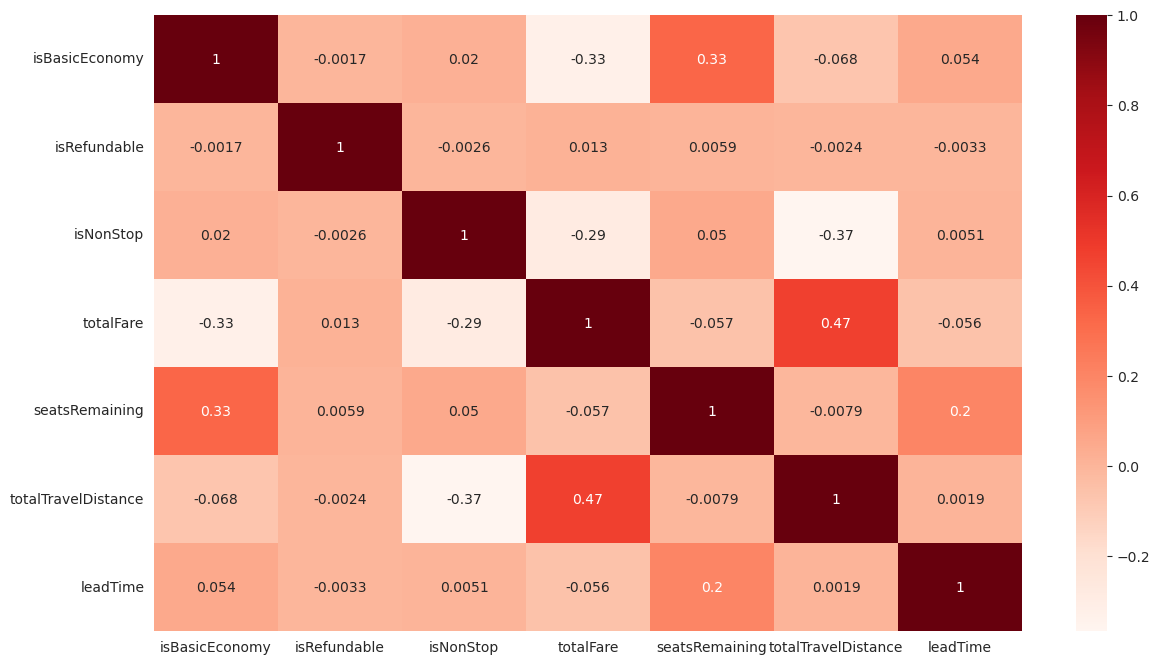

In [56]:
#testing for multicolinearity with correlation matrix
#source: Professor Holowczak Pizzeria Pipeline

vector_column = "correlation_features"

numeric_columns = ["isBasicEconomy", "isRefundable", "isNonStop", "totalFare", "seatsRemaining", "totalTravelDistance", "leadTime"]
assembler = VectorAssembler(inputCols=numeric_columns, outputCol=vector_column)
sdf_vector = assembler.transform(sdf).select(vector_column)

matrix = Correlation.corr(sdf_vector, vector_column).collect()[0][0]
correlation_matrix = matrix.toArray().tolist() 

correlation_matrix_df = pd.DataFrame(data=correlation_matrix, columns=numeric_columns, index=numeric_columns) 

heatmap_plot = plt.figure(figsize=(14,8))  
sns.set_style("white")

sns.heatmap(correlation_matrix_df, 
            xticklabels=correlation_matrix_df.columns.values,
            yticklabels=correlation_matrix_df.columns.values,  cmap="Reds", annot=True)
plt.savefig("corr_matrix.png")


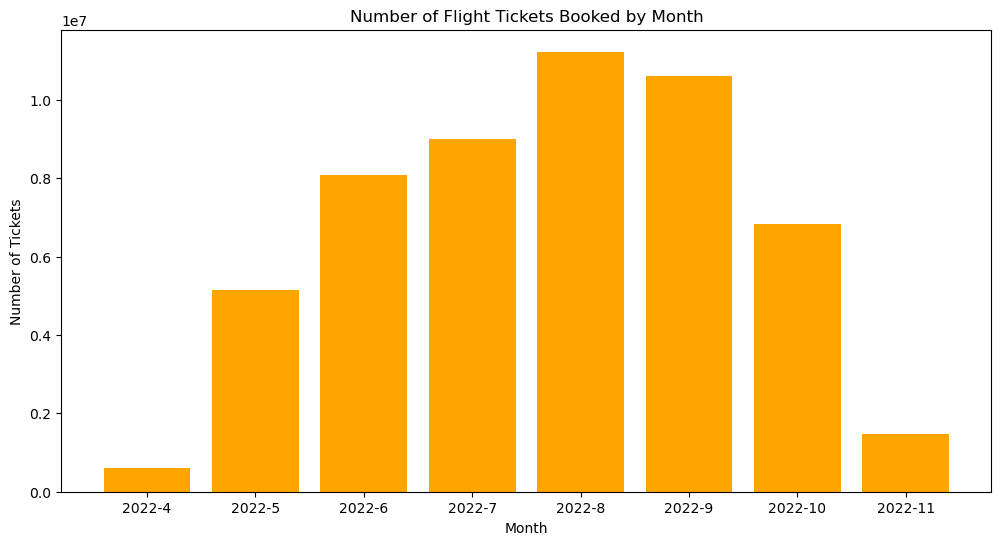

In [17]:
# number of tickets booked by flightdate
df = spark.read.parquet(parquet_path)

monthly_data = (
    df.groupBy(
        year("flightDate").alias("year"),
        month("flightDate").alias("month")
    )
    .agg(count("*").alias("num_tickets"))
    .orderBy("year", "month")
)
    
monthly_data_df = monthly_data.toPandas()

monthly_data_df["year_month"] = monthly_data_df["year"].astype(str) + "-" + monthly_data_df["month"].astype(str)

plt.figure(figsize=(12, 6))
plt.bar(monthly_data_df["year_month"], monthly_data_df["num_tickets"], color="orange")
plt.title("Number of Flight Tickets Booked by Month")
plt.xlabel("Month")
plt.ylabel("Number of Tickets")
plt.show()

24/12/09 01:21:40 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB


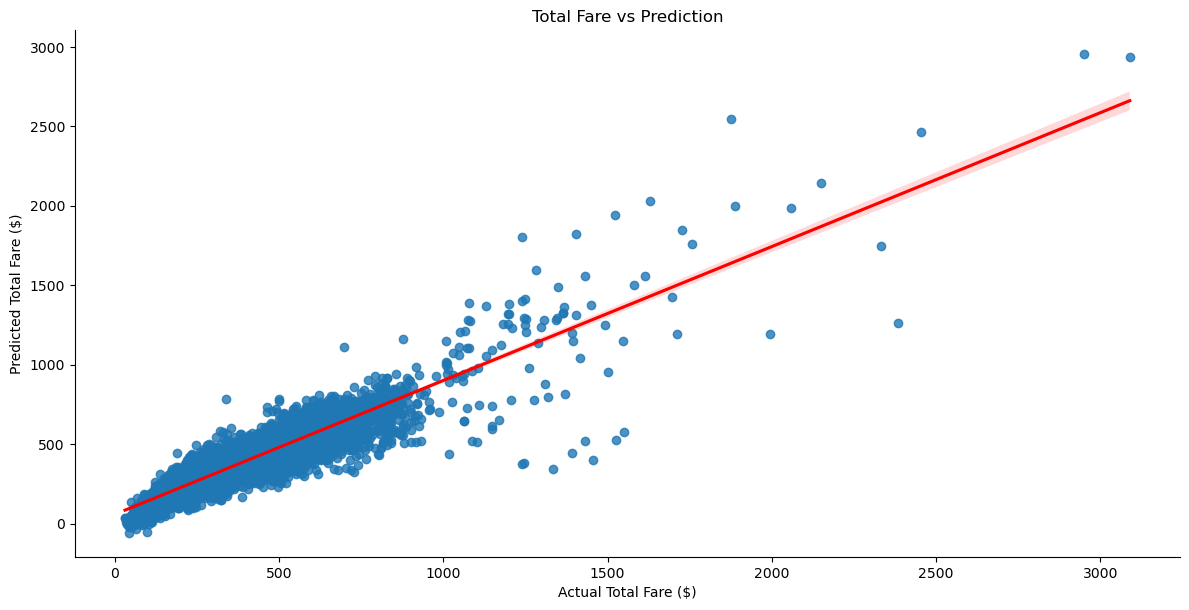

In [51]:
# Actual vs Predicted Total Fares
predictions_sample = test_results.select('totalFare', 'prediction').sample(False, 0.10).toPandas()
predictions_sample = predictions_sample.sample(n=10000)

sns.lmplot(
    x="totalFare",
    y="prediction",
    data=predictions_sample,
    height=6,
    aspect =2,
    line_kws={'color': 'red'}
)

plt.xlabel("Actual Total Fare ($)")
plt.ylabel("Predicted Total Fare ($)")
plt.title("Total Fare vs Prediction")
plt.show()

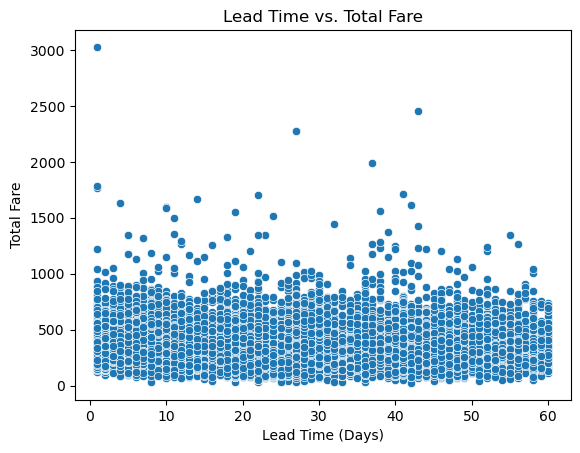

In [43]:
#Lead Time vs Total Fare
lead_sample = test_results.select('leadTime', 'totalFare').sample(False, 0.10)
lead_sample_df = lead_sample.toPandas()

lead_sample_df = lead_sample_df.sample(n=10000, random_state=42)


sns.scatterplot(data=lead_sample_df, x="leadTime", y="totalFare")
plt.title("Lead Time vs. Total Fare")
plt.xlabel("Lead Time (Days)")
plt.ylabel("Total Fare")
plt.show()

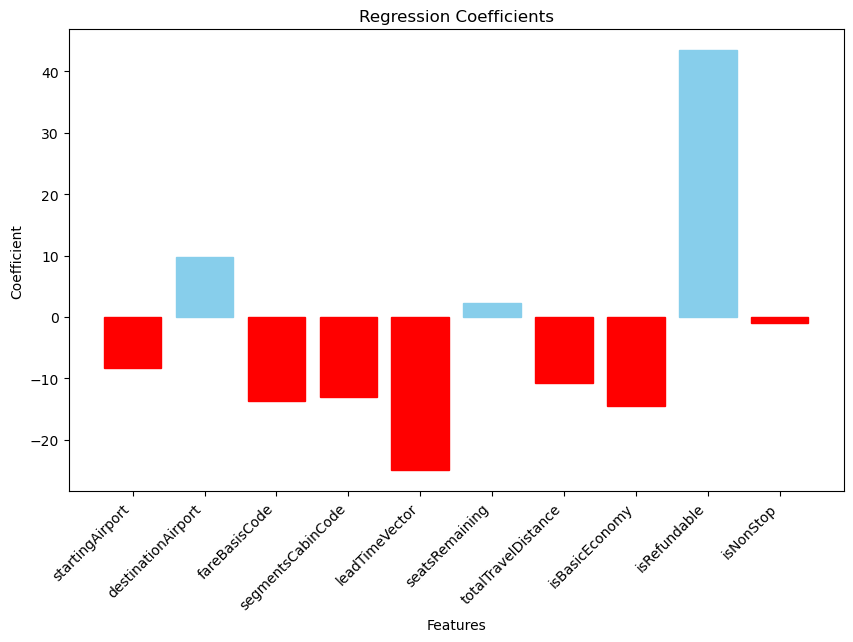

In [55]:
#Graphing the Regression Coefficients
features = [
    "startingAirport",
    "destinationAirport",
    "fareBasisCode",
    "segmentsCabinCode",
    "leadTimeVector",
    "seatsRemaining",
    "totalTravelDistance",
    "isBasicEconomy",
    "isRefundable",
    "isNonStop"
]
coefficients = [
    -8.30656155389394,
    9.784928188016835,
    -13.730653522312096,
    -12.969003989814462,
    -25.016123803734743,
    2.1965408000848656,
    -10.804132708554793,
    -14.520793272952583,
    43.41599151287904,
    -1.0133197541417462
]

plt.figure(figsize=(10, 6))
bars = plt.bar(features, coefficients, color='skyblue')
for bar in bars:
    if bar.get_height() > 0:
        bar.set_color('skyblue')
    else:
        bar.set_color('red')

plt.xticks(rotation=45, ha='right')
plt.title("Regression Coefficients")
plt.ylabel("Coefficient")
plt.xlabel("Features")

plt.show()